# scRNA-seq notes

10x PBMC data are hosted in https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz

53:00 - scRNA-seq packages

4.12.3 and 4.12.4 sce and scater

## scRNA-seq

Single-cell RNA sequencing (scRNA-seq) is a great tool to allow us to see at cellular resolution that you can't get using bulk RNA-seq which only measures average expression levels across all cells. scRNA-seq can estimate the distribution of expression levels across the cells in your sample making it ideal for studying heterogenous cell populations. It also has the advantage of sampling all transcripts in your sample in an unbiased way, unlike microarrays and RT-qPCR which are limited to a limited set of transcripts. This means that scRNA-seq is great for:
- Identifying rare cell types
- Studying cell differentiation during development
- Building gene atlases
- Study changes in cell composition due to disease or environmental factors

**scRNA-seq protocols**

There are many scRNA-seq protocols available and the dataset sizes from these are continually growing:

<img src="imgs/scRNA-seq_protocols.png" width = 600>

*Summary of some of the more popular scRNA-seq protocols. Chen, Teichman and Meyer, 2018. Abbreviations: cDNA, complementary DNA; DNA pol I, DNA polymerase I; FACS, fluorescence-activated cell sorting; PCR, polymerase chain reaction; RNase H, ribonuclease H; RT, reverse transcription; TSO, template-switching oligonucleotide*

Protocols usually follow these steps:
1. Cells in a solid sample are dissociated
2. (optional: cells can be selected for using markers, fluorescent transgenes or staining dyes)
3. They are then isolated and captured. Three methods for this are:
    - **Microtitre-plate-based methods** - cells are put in individual wells using things like pipetting, microdissection of fluorescent activated cell sorting (FACS). This method allows you to take pictures of the cells so you can remove damage cells or wells that have more than one cell (known as doublets). FACS also lets you sort cells by things like cell size or intensity of labels and place them in specific wells to give you some more infomation for your downstream analysis. However, this method is work-intestive so is low-throughput.
    - **Microfluidic-array-based methods** - these are efficient methods that combines cell capture with library preparation so is high-throughput. However, it only captures around 10% of cells so is not good for rare cell types or small samples. Also, the nanowells used are customised for particular sizes which can introduce some bias when studying tissues.
    - **Microgluidic-droplet-based methods** - these are the most popular methods used today and have the highest through-put. Cells are trapped in an nanoliter-sized oil droplet with a bead. This bead has the things needed to make the library and a unique barcode that is attached to all reads from one cell. This means that sequencing can be done on all cells together.
4. RNA is extracted
5. Then it is reverse-transcribed into cDNA
6. cDNA is then amplified (by *in vitro* transcription or PCR)
7. This is then built into a sequencing library
8. Sequencing using NGS
9. An expression matrix can then be used for further analysis

<img src="imgs/scRNA-seq_workflow.png" width = 550>

*scRNA-seq workflow. Taken from wikipedia https://en.wikipedia.org/wiki/Single_cell_sequencing*

The protocol you choose to use will depend on study design and aims. If you want to find a rare cell populatation, you will want to sequence more cells (e.g. 10x Chromium), but if you want to study a particular known cell type, it may be better to sequence fewer cells at a higher resolution (e.g. using SMART-seq2). How many cells needed can be estimated here: https://satijalab.org/howmanycells/ and https://satijalab.org/costpercell/. As different protocols can have variations in accuracy and sensitivity (how much starting RNA is needed), you can also look at studies comparing different protocols: Ziegenhaln et al, 2017; Scensson et al, 2017, Ding et al, 2020.

**Drawbacks**

There are a few problems that come with scRNA-seq:
- Low amount of RNA from cells can cause complications:
    - **Amplification** is needed which can lead to biases in the data.
    - **'Dropouts'** occur when some tramscripts are not captured before amplification. It means some cells this gene will appear to have no expression so data will have many zeros. The low coverage also contributes to this so the resulting matrix is said to be a sparse matrix.
- Unlike bulk RNA-seq, it is difficult to have replicates as the libraries represent a single cell, rather than a cell population, so distinguishing technical noise and biological variability is tricky. However, two methods can be used to do this:
    - **Spike-ins** - this allows you to normalise the data by adding in synthetic RNA molecules at a known concentration. The most commonly used are a set of 96 spikes from the External RNA Control Consortium (ERCC). But recently, droplet-based methods are more popular so spike-ins not used much anymore. 
    - **UMIs** - these unique molecular identifiers are 4-20 bp barcodes added to the 3' or 5' end of each transcript before amplification which is followed by targeted sequencing of the 3' or 5' end of the transcripts. This allows you to quantify the number of transcripts before amplification.
- Batch effects caused by confounding variables when different samples are processed seperately

<img src="imgs/batch_effects.png" width = 600>

*Visualisation of how batch effects affect data. Hicks et al, 2018*

## Processing raw scRNA-seq data: making an expression matrix

### Quality control

The output of scRNA-seq is usually in the form of a **FastQ** file which have this format:

>\>ReadID <br>
>CDNA READ SEQUENCE
>    
>+
>
>SEQUENCING QUALITY SCORES

*Read quality*

The first step after getting the FastQ file is to check the quality of the reads. Before we get this file, reads of low quality will have been removed and the data will have been normalised to account for amplification. Checking read quality can be done using a tool call FastQC which can be used for both bulk and single-cell RNA-seq data. FastQC outputs a report on the read quality using the quality scores in the FastQ file.

https://www.bioinformatics.babraham.ac.uk/projects/fastqc/

Run FastQC using the following command:

`fastqc -o output_directory fastQ_file`

This will prodyce a zip and html file for each of the paired-end reads. The report is in the html file. 

<img src="imgs/FastQC.png" width = 600>

*Quality report from FastQC. Quality is poor at the ends as a result of sequencing. Note 2 bases in the middle have poor quality scores and this will need to be acounted for. Taken from https://www.singlecellcourse.org/*

*Trimming reads*

Next, these low quality bases need to be trimmed off reads. Sequencing also tends to have sequencing adapters, low quality regions at the ends and poly-A sequences, so these can be trimmed too. This can be done using Trim Galore! which is a wrapper for the reads trimming software cutadapt. If UMIs are used, it is not necessary to trim the read with the UMI and cell barcode, just the one with the transcript. 

<img src="imgs/UMIs.png" width = 300>

*Protocols that use paired-end sequencing may have barcodes on one or both reads. When UMIs are used, one read will have the cell and UMI barcodes, while the other will contain the transcript sequence. Read 1s capture the transcript sequence, while read 2 contains the cell barcode and UMI. Adapted from https://www.singlecellcourse.org/*

This can be run using the following command:

`trim_galore --nextera -o output_directory FastQ_file`

After this is done, another FastQC report should be made to check the read quality again.

### Read alignment: mapping cDNA fragments to a reference

The next step is to find out which genes our reads correspond to. We do this by mapping them to a reference genome. There are many tools for this. If spike-ins are used, the reference should have the spike-in sequence added first. UMIs/barcodes should also be removed, these can be added to the read name. Also, before aligning, cells should be checked to see if they have enough mappable reads (~60-70% - but it is important to compare with other cells in the sample and remove outliers). Cells with a low proportion of mappable reads could indicate contamination and should be removed. Below are two:

**Traditional aligners e.g. STAR, hisat2 and TopHat** - STAR tries to find the longest possible seuence which matches the sequences in the reference genome. It is able to find regions where the read spans more than one exon making it a 'splice aware' aligner. This means it can align genomes rather than transcriptomes and be used to study alternative splicing or chromosomal rearragements. 

<img src="imgs/STAR.png" width = 300>

*STAR is able to match sequences that span a splicing junction. Dobin et al, 2013*

You need to provide the reference genome (**FASTA file**) and annotations (GTF) which STAR uses to make a genome index. STAR then aligns the reads to this. Run STAR using this command:

`STAR --runThreadN 4 --runMode genomeGenerate --genomeDir output_directory --genomeFastaFiles reference_fasta_file`

The output is a **BAM file** which stores the mapped reads. The human-readable version is called a SAM file. It includes information like the mapping quality and the read's position. BAM files can be viewd using IGV. Sometimes sequencing methods provide BAM files only; therefore, these will need to be converted to FastQ files using bedtools/Picard to perform the QC. CRAM files are similar to BAM files but are more compressed and can be converted to BAM files using samtools. 

**Pseudo-aligners e.g. Kallisto or Salmon** - these map k-mers, rather than reads, to a reference genome. K-mers are sequences of k length from a read. Psuedo-alignment is much faster than alignment and may be more robust to sequencing errors as it would only affect some, but not all, of the k-mers of a read. Pseudo-aligners, unlike traditional aligners, map to a reference transcriptome, rather than a reference genome meaning they map to isoforms rather than genes. Expectation-Maximisation (EM) algorithm is then used to find the optimal distribution of reads that can be mapped to more than one transcripts. It is worth noting that these do not return BAM files, so you cannot visualise the alignment, but they do also perform the read quantification step. Aligning to a transcriptome is difficult because:
- scRNA-seq has lower coverage than bulk RNA-seq
- Many protocols have a 3' coverage bias, so it is hard to tell which isoform a read came from if they that differ at the 5' end.
- Some protocols have short read lengths which also make it challenging to tell which isoform a read came from

Kallisto mitigates this by assigning reads that could map to multiple isoforms to an equvilance class so downstream analyses like clusering use this instead.  

*Alignment QC*

After the reads have been mapped to the genome, the quality of the mapping needs to be evaluated. Tools like RSeQC can be used. As before, look at the whole dataset and remove outliers. It can be done by looking at:
- Total number of reads per cell
- Per cell, the proportion of:
    - Reads mapping to rRNA/tRNA
    - Uniquely mapping reads
    - Reads mapping over splice juntions
    - Unmapped reads
- Read depth along the transcripts

<img src="imgs/gene_coverage.png" width = 300>

*Percentage coverage of a gene body. This shows that many sequencing protocols have a 3' bias. Each line represents a cell. The lines that fall below the others will be removed in the QC step. Taken from https://www.singlecellcourse.org/*

### Genome annotation: assigning reads to genes

Reference genomes are usually in FASTA format. The two most popular sources of assembly files are:
- **UCSC** e.g. hg19, hg38, mm10
- **GRC** e.g. GRChr37, GRChr38, GRCm38
These match e.g. hg38 = CRCh38 but differ in additional contigs and ALT loci.

Genome annotation tell you when genes are and things like the exon-intron boundaries. It is usually given in either GTF or GFF3 file formats from places like RefSeq, ENSEMBL and GENCODE. Gene names start with ENSG and transcripts ENST.

### Demultiplexing: assigning reads to cells

Demultiplexing tells you which read belongs to which cell by combining all the reads with the same cell barcode (and then removing the barcodes) and is done differently depending on the protocol used. The tool that can be applied to most protocols is zUMIs which can be used for most UMI-based protocols. A new method called 'cell hashing' (Stoeckius et al, 2018) increases throughput by attaching oligo tags to cells membranes which can be later demultiplexed.

### Transcript quantification: counting the number of RNA molecules

Next, we need to quantify the expression level of each gene for each cell. There are two types of transcript quantification:
- **Full-length** - these try to achieve uniform read coverage across the whole transcript. It lets you detect splice variants but can only be done by plate-based protocols and may be subject to 3' bias.
- **Tag-based** - these only capture either the 3' or 5' ends of the trancript. This is useful when combined with UMIs which is an improvement on the full-length method as the PCR amplification step can lead to unequal representation of transctipts. The UMI can be used to adjust the transcript count to get the true trancript abundance. Having said this, as the whole transcript is not used, it can be difficult to distinguish between different isoforms. The 10x Chromium protocol uses this method.

For non-UMI scRNA-seq data, tools for bulk RNA-seq can be used like HT-seq and FeatureCounts.

scRNA-seq data that do include UMIs, there aren't as many unique UMI comninations as molecules per cell, so barcodes will be assigned to more than one transcript. This means that we have to use the mapping location as well as the UMI to identify molecules. You might assume that every unique UMI-transcript pair correlates to all reads from a sinlge RNA molcule, but this is not always true because:
1. UMI sequences can change - this can be because of PCR/sequencing errors or base-pair substitotion and is more common in longer UMIs (7-10% of 10bp UMIs). Overestimation of the number of transcripts can happen if this isn't corrected. It can be detected using UMI-tools.
2. Mapping errors/multimapping reads - this means that some UMIs are assigned to the wrong gene/transcript, usually because the transcripts are very similar, resulting in an overestimation of transcripts. It can be mitigated by remocing UMIs with few reads that prove their association with a transcript or by removing all multi-mapping reads. Mire recently, a strategy of splitting read counts can be used e.g. if a read alligns to equally well to 3 paralogous genes, then each paralog gets 1/3 count.
3. Sometimes the same UMI can attach to different mRNA molcules from the same gene, especially when using short UMIs. This can lead to underestimation of transcripts. A collision probablity has been proposed by Grun et al, 2014.

<img src="imgs/UMIs2.png" width = 400>

*Description of points 1-3 where UMIs may correspond to the wrong transcript. Bottom: Lack of UMIs results in transcripts from different genes having the same UMI, so mapping is needed. Adapted from https://www.singlecellcourse.org/*

*Normalisation*

Some downstream analyses use raw read counts, but its mostly accepted that within-sample normalisation should be done first. The most popular method is Trancripts per Million (TPM) which is calulated by `(trancript length) - (cDNA fragment size) + 1`. The results are then scaled linearly to add up to one million. This corrects for these biases:
- Each sample is sequenced at a different depth
- Longer genes mean more cDNA fragments

### 10x Chromium (Cell Ranger)

Cell Ranger is the default tool for processing 10x Genomic Chromium scRNA-seq data. It follows this process:
1. Splice-aware alignment of reads to the reference genome using STAR
2. Annotation using GTF - marks whether a read is exonic, intronic or intergenic. Also tells you whether the reads align well to the genome.
3. Mapping quality adjustments - if a read maps to both an exon and one (or more) non-exons, the exon will be prioritised and is given the maximum mapping quality score.
4. Aligns exonic and intronic reads to annotated transcripts. They are also assigned as either sense or antisense. 
5. Reads that are transcriptomic and are not multimapping are used for UMI counting (intronic reads can be included for experiments using nuclei as many of the RNAs will not have been spliced).~

## scRNA-seq analysis in R using Bioconductor

Once the above steps have been completed, it is time to import the data into R. Data usually starts in the form of a matrix of counts (reads or UMIs) of features in samples, where features could be genes, isoforms or exons. A collection of packages, known as Bioconductor, can then be used to analyse your data. These packages have standardardised so packages can be combined within pipelines. One example of this is the standard data object is the `SingleCellExperiment` (SCE) class which stores information about a scRNA-seq experiment, like genome location etc. 

<img src="imgs/sce.png" width = 500>

*Structure of the SingleCellExperiment object. Information about genes are stored in rows and can be obtained using the `rowData` function, while information about cells are stored in columns and can be accessed using the `colData` function. Taken from https://www.singlecellcourse.org/*

More on this can be found here: https://bioconductor.org/books/release/OSCA/


In this section, data from Tung et al, 2017 (file named: GSE77288_molecules-raw-single-per-sample.txt.gz) will be used to demonstrate. These data are from an experiment using induced pluripotent stem cells from three individuals. It was carried out with the Fluidigm C1 plateform and used both UMIs and ERCC spike-ins for quanification. 

**Read in data**

In [1]:
# Read the counts dataset

tung_counts <- read.table('datasets/tung/counts.txt', sep = '\t')

In [2]:
# Rows are genes and columns are individual.replicate.well

head(tung_counts)

,NA19098.r1.A01,NA19098.r1.A02,NA19098.r1.A03,NA19098.r1.A04,NA19098.r1.A05,NA19098.r1.A06,NA19098.r1.A07,NA19098.r1.A08,NA19098.r1.A09,NA19098.r1.A10,⋯,NA19239.r3.H03,NA19239.r3.H04,NA19239.r3.H05,NA19239.r3.H06,NA19239.r3.H07,NA19239.r3.H08,NA19239.r3.H09,NA19239.r3.H10,NA19239.r3.H11,NA19239.r3.H12
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000186092,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237683,0,0,0,1,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
ENSG00000235249,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000185097,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000269831,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000269308,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [3]:
# Read in colData

tung_annotation <- read.table('datasets/tung/annotation.txt', sep = '\t')

In [4]:
# Annotations - row names are the col names of the count matrix

head(tung_annotation)

,individual,replicate,well,batch,sample_id
,<chr>,<chr>,<chr>,<chr>,<chr>
NA19098.r1.A01,NA19098,r1,A01,NA19098.r1,NA19098.r1.A01
NA19098.r1.A02,NA19098,r1,A02,NA19098.r1,NA19098.r1.A02
NA19098.r1.A03,NA19098,r1,A03,NA19098.r1,NA19098.r1.A03
NA19098.r1.A04,NA19098,r1,A04,NA19098.r1,NA19098.r1.A04
NA19098.r1.A05,NA19098,r1,A05,NA19098.r1,NA19098.r1.A05
NA19098.r1.A06,NA19098,r1,A06,NA19098.r1,NA19098.r1.A06


In [5]:
# Load the library

suppressMessages(library(SingleCellExperiment))

In [6]:
# Create the SCE object

annotation <- c('individual', 'replicate', 'well')

tung <- SingleCellExperiment(
  assays = list(counts = as.matrix(tung_counts)), # the data must be a matrix
  colData = tung_annotation
)

**Naming assays**

Here are some convensions on naming assays:
- `counts` - Raw count data e.g. number of reads or transcripts for a gene
- `normcounts` - Normalised counts
- `logcounts` - Log-transformed counts
- `cpm` - (counts per million) read count for a gene / library size in millions
- `tpm` - (transcpripts per million) trancripts / total transcripts in millions

Each of these has a function:

**Inspecting sce objects**

In [7]:
head(counts(tung))

# Can also use: assay(tung, 'counts')

,NA19098.r1.A01,NA19098.r1.A02,NA19098.r1.A03,NA19098.r1.A04,NA19098.r1.A05,NA19098.r1.A06,NA19098.r1.A07,NA19098.r1.A08,NA19098.r1.A09,NA19098.r1.A10,⋯,NA19239.r3.H03,NA19239.r3.H04,NA19239.r3.H05,NA19239.r3.H06,NA19239.r3.H07,NA19239.r3.H08,NA19239.r3.H09,NA19239.r3.H10,NA19239.r3.H11,NA19239.r3.H12
ENSG00000186092,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237683,0,0,0,1,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0
ENSG00000235249,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000185097,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000269831,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000269308,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [8]:
tung

class: SingleCellExperiment 
dim: 20419 864 
metadata(0):
assays(1): counts
rownames(20419): ENSG00000186092 ENSG00000237683 ... ERCC-00170
  ERCC-00171
rowData names(0):
colnames(864): NA19098.r1.A01 NA19098.r1.A02 ... NA19239.r3.H11
  NA19239.r3.H12
colData names(5): individual replicate well batch sample_id
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [9]:
# Table of gene metadata

rowData(tung)

DataFrame with 20419 rows and 0 columns

In [10]:
# Table of cell metadata

colData(tung)

DataFrame with 864 rows and 5 columns
                individual   replicate        well       batch      sample_id
               <character> <character> <character> <character>    <character>
NA19098.r1.A01     NA19098          r1         A01  NA19098.r1 NA19098.r1.A01
NA19098.r1.A02     NA19098          r1         A02  NA19098.r1 NA19098.r1.A02
NA19098.r1.A03     NA19098          r1         A03  NA19098.r1 NA19098.r1.A03
NA19098.r1.A04     NA19098          r1         A04  NA19098.r1 NA19098.r1.A04
NA19098.r1.A05     NA19098          r1         A05  NA19098.r1 NA19098.r1.A05
...                    ...         ...         ...         ...            ...
NA19239.r3.H08     NA19239          r3         H08  NA19239.r3 NA19239.r3.H08
NA19239.r3.H09     NA19239          r3         H09  NA19239.r3 NA19239.r3.H09
NA19239.r3.H10     NA19239          r3         H10  NA19239.r3 NA19239.r3.H10
NA19239.r3.H11     NA19239          r3         H11  NA19239.r3 NA19239.r3.H11
NA19239.r3.H12     NA19239

In [11]:
# Check how many cells per batch - access a column of colData using sce$colname

table(colData(tung)$batch)


NA19098.r1 NA19098.r2 NA19098.r3 NA19101.r1 NA19101.r2 NA19101.r3 NA19239.r1 
        96         96         96         96         96         96         96 
NA19239.r2 NA19239.r3 
        96         96 

There are 96 cells per batch which suggests the authors used a 96 well plate (a low-throughput method).

**Modifying sce objects**

You can modify an SCE object by using the `<-` operator:

`assay(sce, 'name_of_new_assay') <- new_matrix`

So, you can use this to do things like make an assay with log-transformed counts data.

In [12]:
assay(tung, 'logcounts') <- log2(counts(tung) + 1) # +1 otherwise log(0) = -inf

In [13]:
# Because we used a conventional assay name, we can use a dedicated function to access it:

logcounts(tung)[1:10, 1:4]

,NA19098.r1.A01,NA19098.r1.A02,NA19098.r1.A03,NA19098.r1.A04
ENSG00000186092,0,0.000000,0,0
ENSG00000237683,0,0.000000,0,1
ENSG00000235249,0,0.000000,0,0
ENSG00000185097,0,0.000000,0,0
ENSG00000269831,0,0.000000,0,0
ENSG00000269308,0,0.000000,0,0
ENSG00000187634,0,0.000000,0,0
ENSG00000268179,0,0.000000,0,0
ENSG00000188976,2,2.807355,1,2
ENSG00000187961,0,0.000000,0,0


Other ways of modifying SCE objects:

In [14]:
#rowData(sce) or colData <- data_frame

#rowData(sce)$rowname or colData(sce)$colname <- values

**Katrix statistics**

As the counts data are stored in a matrix, you can use several functions to get summary statistics.

In [15]:
# Calculate the mean counts per cell

head(colMeans(counts(tung)))

NA19098.r1.A01 NA19098.r1.A02 NA19098.r1.A03 NA19098.r1.A04 NA19098.r1.A05 
      3.101131       3.133160       2.136735       2.640776       3.471620 
NA19098.r1.A06 
      3.332729

In [16]:
# We can add this to colData

colData(tung)$mean_counts <- colMeans(counts(tung))

head(colData(tung))

DataFrame with 6 rows and 6 columns
                individual   replicate        well       batch      sample_id
               <character> <character> <character> <character>    <character>
NA19098.r1.A01     NA19098          r1         A01  NA19098.r1 NA19098.r1.A01
NA19098.r1.A02     NA19098          r1         A02  NA19098.r1 NA19098.r1.A02
NA19098.r1.A03     NA19098          r1         A03  NA19098.r1 NA19098.r1.A03
NA19098.r1.A04     NA19098          r1         A04  NA19098.r1 NA19098.r1.A04
NA19098.r1.A05     NA19098          r1         A05  NA19098.r1 NA19098.r1.A05
NA19098.r1.A06     NA19098          r1         A06  NA19098.r1 NA19098.r1.A06
               mean_counts
                 <numeric>
NA19098.r1.A01     3.10113
NA19098.r1.A02     3.13316
NA19098.r1.A03     2.13674
NA19098.r1.A04     2.64078
NA19098.r1.A05     3.47162
NA19098.r1.A06     3.33273

In [17]:
# Or create a counts per million assay:

# Make a new colData column with the total cell counts
colData(tung)$total_counts <- colSums(counts(tung))

# Use the function sweep() which takes: 
#       - matrix to normalise
#       - dimention to normalise along (1 = rows, 2 = cols)
#       - statistics to normalise by
#       - function to use for normalisation

assay(tung, "cpm") <- sweep(counts(tung), 2, tung$total_counts/1e6, '/') # divide by 1e6 so in units of millions

head(cpm(tung))

,NA19098.r1.A01,NA19098.r1.A02,NA19098.r1.A03,NA19098.r1.A04,NA19098.r1.A05,NA19098.r1.A06,NA19098.r1.A07,NA19098.r1.A08,NA19098.r1.A09,NA19098.r1.A10,⋯,NA19239.r3.H03,NA19239.r3.H04,NA19239.r3.H05,NA19239.r3.H06,NA19239.r3.H07,NA19239.r3.H08,NA19239.r3.H09,NA19239.r3.H10,NA19239.r3.H11,NA19239.r3.H12
ENSG00000186092,0,0,0,0.00000,0,0,0,0,0,0,⋯,0,0.00000,0,0,0,0,0,0,0,0
ENSG00000237683,0,0,0,18.54531,0,0,0,0,0,0,⋯,0,12.56202,0,0,0,0,0,0,0,0
ENSG00000235249,0,0,0,0.00000,0,0,0,0,0,0,⋯,0,0.00000,0,0,0,0,0,0,0,0
ENSG00000185097,0,0,0,0.00000,0,0,0,0,0,0,⋯,0,0.00000,0,0,0,0,0,0,0,0
ENSG00000269831,0,0,0,0.00000,0,0,0,0,0,0,⋯,0,0.00000,0,0,0,0,0,0,0,0
ENSG00000269308,0,0,0,0.00000,0,0,0,0,0,0,⋯,0,0.00000,0,0,0,0,0,0,0,0


In [18]:
# See if the columns add up to 1e6 to check if it is correct

head(colSums(cpm(tung)))

NA19098.r1.A01 NA19098.r1.A02 NA19098.r1.A03 NA19098.r1.A04 NA19098.r1.A05 
         1e+06          1e+06          1e+06          1e+06          1e+06 
NA19098.r1.A06 
         1e+06

**Subsetting SCE objects**

Like a matrix or dataframe, you can use `[row, col]` to subset an SCE object.

In [19]:
gene_means <- rowMeans(counts(tung))

# Use logical operator outside the brackets to get if TRUE or FALSE
gene_means[1:10] > 0.01

ENSG00000186092 ENSG00000237683 ENSG00000235249 ENSG00000185097 ENSG00000269831 
          FALSE            TRUE           FALSE           FALSE           FALSE 
ENSG00000269308 ENSG00000187634 ENSG00000268179 ENSG00000188976 ENSG00000187961 
          FALSE            TRUE           FALSE            TRUE            TRUE

In [20]:
# Use logical operator inside the brackets to filter the data

tung[gene_means > 0.01, ]

class: SingleCellExperiment 
dim: 16052 864 
metadata(0):
assays(3): counts logcounts cpm
rownames(16052): ENSG00000237683 ENSG00000187634 ... ERCC-00170
  ERCC-00171
rowData names(0):
colnames(864): NA19098.r1.A01 NA19098.r1.A02 ... NA19239.r3.H11
  NA19239.r3.H12
colData names(7): individual replicate ... mean_counts total_counts
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

A common use is to only keep cells with a certain number of genes above a certain threshold of expression.

In [23]:
# First, check which genes have expression over a certain threashold:

over_zero <- counts(tung) > 0
over_zero[1:5, 1:8]

,NA19098.r1.A01,NA19098.r1.A02,NA19098.r1.A03,NA19098.r1.A04,NA19098.r1.A05,NA19098.r1.A06,NA19098.r1.A07,NA19098.r1.A08
ENSG00000186092,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
ENSG00000237683,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE
ENSG00000235249,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
ENSG00000185097,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
ENSG00000269831,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE


In [28]:
# As TRUE is encoded as 1 and FALSE is encoded as 0, we can calculate the total number of genes over the threashold

total_detected_per_cell <- colSums(counts(tung) > 0)
total_detected_per_cell[1:8]

NA19098.r1.A01 NA19098.r1.A02 NA19098.r1.A03 NA19098.r1.A04 NA19098.r1.A05 
          8368           8234           7289           7985           8619 
NA19098.r1.A06 NA19098.r1.A07 NA19098.r1.A08 
          8659           8054           9429

In [29]:
# Finally, we can select for cells with a minimum number of detected genes

tung[, total_detected_per_cell > 5000]

class: SingleCellExperiment 
dim: 20419 849 
metadata(0):
assays(3): counts logcounts cpm
rownames(20419): ENSG00000186092 ENSG00000237683 ... ERCC-00170
  ERCC-00171
rowData names(0):
colnames(849): NA19098.r1.A01 NA19098.r1.A02 ... NA19239.r3.H11
  NA19239.r3.H12
colData names(7): individual replicate ... mean_counts total_counts
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

Notice there the SCE object has fewer cells than before. Here are some useful filters:

Total counts per cell greater than x - `colSums(counts(sce)) > x`

Cells with at least y genes having counts greater than x - `colSums(counts(sce) > x) > y`

Total counts per gene greater than x - `rowSums(counts(sce)) > x`

Genes with at least y cells having counts greater than y - `rowSums(counts(sce) > x) > y`

**Visualising the data**

We can use ggplot2 to make plots. For this, we need to make our data into a dataframe first. Also, the Bioconductor package scater has some helper functions for retrieving from SCE objects.

You can visualise the distribution of the total counts per cell for each batch

In [33]:
# First, convert the colData into a dataframe

cell_metadata <- as.data.frame(colData(tung))

head(cell_metadata)

,individual,replicate,well,batch,sample_id,mean_counts,total_counts
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
NA19098.r1.A01,NA19098,r1,A01,NA19098.r1,NA19098.r1.A01,3.101131,63322
NA19098.r1.A02,NA19098,r1,A02,NA19098.r1,NA19098.r1.A02,3.133160,63976
NA19098.r1.A03,NA19098,r1,A03,NA19098.r1,NA19098.r1.A03,2.136735,43630
NA19098.r1.A04,NA19098,r1,A04,NA19098.r1,NA19098.r1.A04,2.640776,53922
NA19098.r1.A05,NA19098,r1,A05,NA19098.r1,NA19098.r1.A05,3.471620,70887
NA19098.r1.A06,NA19098,r1,A06,NA19098.r1,NA19098.r1.A06,3.332729,68051


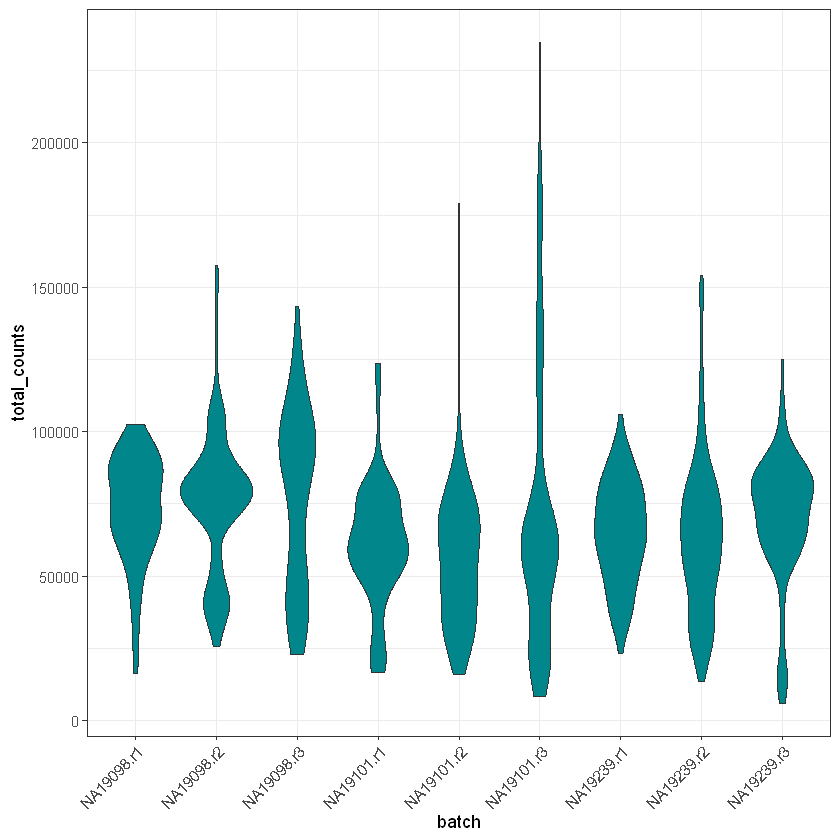

In [37]:
# Next, use ggplot2 to visualise with a violin plot. The x axis is the batch and the y axis are the total counts

library(ggplot2)

ggplot(data = cell_metadata, aes(x = batch, y = total_counts)) +
  geom_violin(fill = 'turquoise4') + theme_bw() + 
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

You can also check a distribution of a gene for each batch. This is a bit more complicated as our batch data are in the colData, whereas the gene expression data are stored in the counts assay. We need these in the same dataframe to be used by ggplot2. This is where we can use the scater package. It contains the `ggcells` function that lets us specify the information we need for the plot.

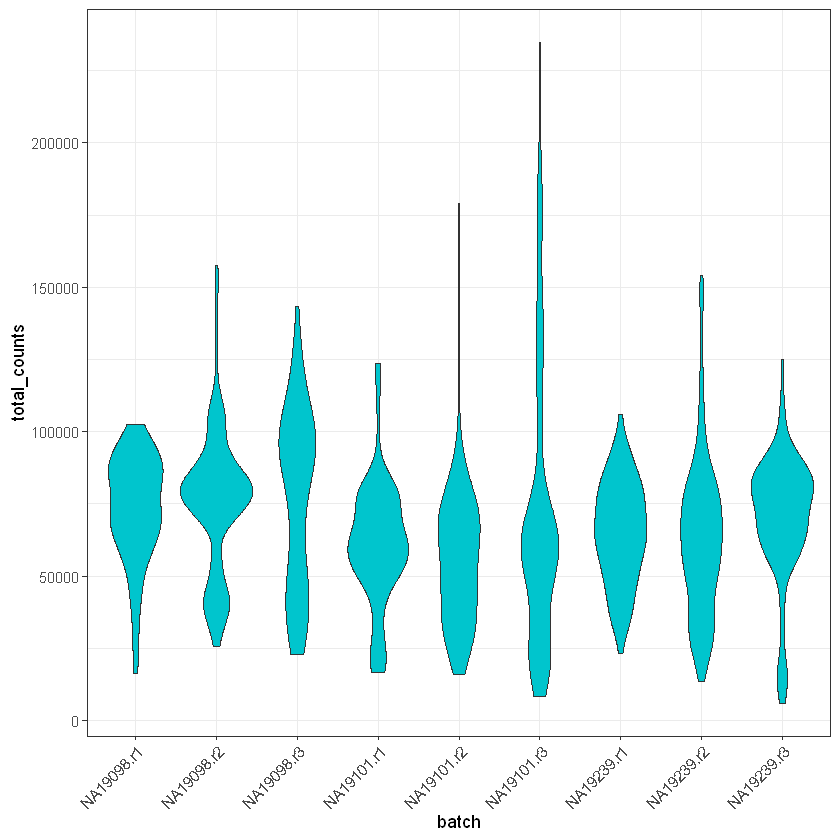

In [42]:
# This is the same plot as above, but we don't need to make the dataframe first

library(scater)

ggcells(tung, aes(x = batch, y = total_counts)) + 
  geom_violin(fill = 'turquoise3') + theme_bw() + 
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

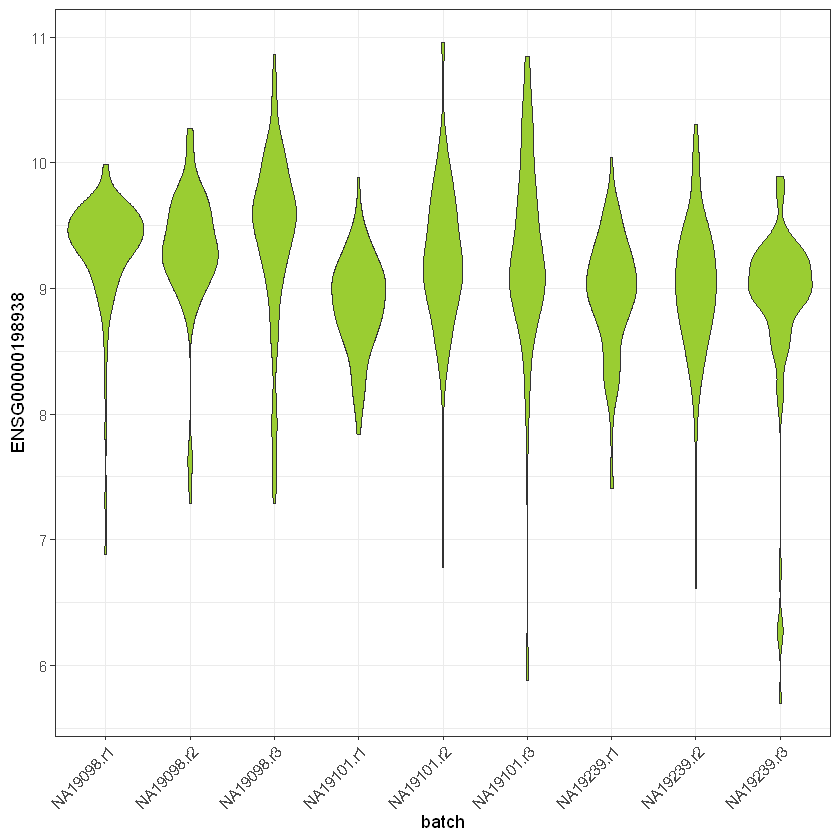

In [43]:
# Now to plot the expresssion of one of our genes in each batch:

ggcells(tung, aes(x = batch, y = ENSG00000198938), exprs_values = "logcounts") + 
  geom_violin(fill = 'yellowgreen') + theme_bw() + 
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

We can also plot scatter plots. For example, we can plot the relationship between the mean and variance of raw counts (coloured by batch).

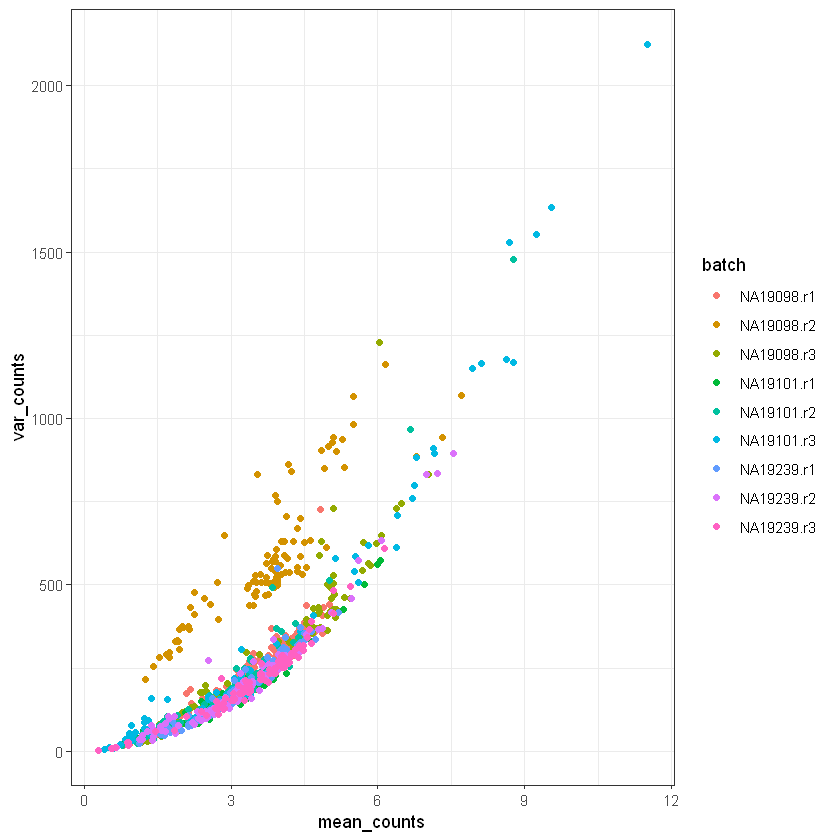

In [45]:
# First, add a new column to our colData with the variance

colData(tung)$var_counts <- colVars(counts(tung))

# Now, make the plot

ggcells(tung, aes(mean_counts, var_counts)) +
  geom_point(aes(colour = batch)) + theme_bw()

The plot shows that there is a positive correlation between the mean and variance of out counts. This is common with count data, so it is important to use tools that model the mean-variance relationship properly so that we know if genes are actually variable in our dataset, and not just variable because it's highly expressed.

## Quality control and exploration

We now need to look at the expression matrix and remove things like low quality cells that may cause noise which will impact our downstream analyses. As there is currently no standard method for scRNA sequencing, so the exact values for the QC steps will vary between experiments. This means that instead we will be looking for outliers in our dataset. It also means that care should be taken if you want to compare QC metrics between experiments using different protocols.

**Converting ENSEMBL IDs to gene names (symbols)**

To get a better idea of our data, it's useful to convert the ENSEMBL IDs into names we can easily understand.

In [58]:
# We'll be using these Bioconductor packages

suppressMessages(library(scater))
suppressMessages(library(SingleCellExperiment))
suppressMessages(library(AnnotationDbi))
suppressMessages(library(org.Hs.eg.db))
suppressMessages(library(EnsDb.Hsapiens.v86))

In [62]:
# First, we store the ERCC data we don't need in altExp and remmove ERCC features from the main object

altExp(tung,"ERCC") <- tung[grep("^ERCC-",rownames(tung)), ]
tung <- tung[grep("^ERCC-",rownames(tung),invert = T), ]

tung # Note the altExpNames section now contains ERCC

class: SingleCellExperiment 
dim: 20327 864 
metadata(0):
assays(3): counts logcounts cpm
rownames(20327): ENSG00000186092 ENSG00000237683 ... ENSG00000172288
  ENSG00000269393
rowData names(0):
colnames(864): NA19098.r1.A01 NA19098.r1.A02 ... NA19239.r3.H11
  NA19239.r3.H12
colData names(8): individual replicate ... total_counts var_counts
reducedDimNames(0):
mainExpName: NULL
altExpNames(1): ERCC

In [65]:
# Now we can change the ENSEMBL IDs to the gene symbols using mapIds from the AnnotationDbi package. 
# This retuns one symbols per ID, but adding the multiVals argument can return more

gene_names <- mapIds(org.Hs.eg.db, keys=rownames(tung), keytype="ENSEMBL", columns="SYMBOL",column="SYMBOL")

rowData(tung)$SYMBOL <- gene_names # Add this information to the rowData
table(is.na(gene_names)) # Find out how many genes with no gene names. FALSE = could be annotated.

'select()' returned 1:many mapping between keys and columns




FALSE  TRUE 
18933  1394 

In [67]:
# Now we should remove the genes where the gene names couldn't be found

tung <- tung[! is.na(rowData(tung)$SYMBOL),]

The next step is to see if there are any ribosomal proteins using the new gene symbols.

In [74]:
# These gene names will begin with RPL or RPS

ribo <- grep("^RP[LS]",rowData(tung)$SYMBOL,value = T)
ribo[1:10]

ENSG00000116251 ENSG00000142676 ENSG00000117676 ENSG00000142937 ENSG00000122406 
        "RPL22"         "RPL11"       "RPS6KA1"          "RPS8"          "RPL5" 
ENSG00000177954 ENSG00000136643 ENSG00000138326 ENSG00000177600 ENSG00000166441 
        "RPS27"       "RPS6KC1"         "RPS24"         "RPLP2"        "RPL27A"

We can also look to mitochondrial proteins.

In [75]:
# These gene names will begin with 'MT-'

grep("^MT-",rowData(tung)$SYMBOL,value = T)

named character(0)

This returns no values. A quick look at the data shows that the mitochondrial protein ATP8 is present, but does not start with MT-. Most modern annotations do start with MT-. Annotations problems like this are quite common. Another problem is we cannot find the gene locations as this is not supported by `org.Hs.eg.db`. Let's try a different database:

In [77]:
ensdb_genes <- genes(EnsDb.Hsapiens.v86)
MT_names <- ensdb_genes[seqnames(ensdb_genes) == "MT"]$gene_id
is_mito <- rownames(tung) %in% MT_names
table(is_mito)

is_mito
FALSE  TRUE 
18920    13 

**Basic QC**

The `scater` package allows us to calculate some QC metrics.

In [79]:
tung_cell <- perCellQCMetrics(tung,subsets=list(Mito=is_mito))

head(tung_cell)

DataFrame with 6 rows and 9 columns
                     sum  detected subsets_Mito_sum subsets_Mito_detected
               <numeric> <numeric>        <numeric>             <numeric>
NA19098.r1.A01     61706      8242             4883                    13
NA19098.r1.A02     62298      8113             3732                    13
NA19098.r1.A03     42211      7188             3089                    13
NA19098.r1.A04     52323      7862             3606                    13
NA19098.r1.A05     69193      8495             4381                    13
NA19098.r1.A06     66341      8535             3235                    13
               subsets_Mito_percent altexps_ERCC_sum altexps_ERCC_detected
                          <numeric>        <numeric>             <numeric>
NA19098.r1.A01              7.91333                0                     0
NA19098.r1.A02              5.99056                0                     0
NA19098.r1.A03              7.31800                0                    

In [81]:
tung_feature <- perFeatureQCMetrics(tung)

head(tung_feature)

DataFrame with 6 rows and 2 columns
                     mean  detected
                <numeric> <numeric>
ENSG00000186092 0.0000000   0.00000
ENSG00000187634 0.0300926   2.77778
ENSG00000188976 2.6388889  84.25926
ENSG00000187961 0.2384259  20.60185
ENSG00000187583 0.0115741   1.15741
ENSG00000187642 0.0127315   1.27315

We can then add these to our SCE object.

In [83]:
tung <- addPerCellQC(tung, subsets=list(Mito=is_mito)) # this will be added to colData
tung <- addPerFeatureQC(tung) # this will be added to colRow

tung

class: SingleCellExperiment 
dim: 18933 864 
metadata(0):
assays(3): counts logcounts cpm
rownames(18933): ENSG00000186092 ENSG00000187634 ... ENSG00000185894
  ENSG00000172288
rowData names(5): SYMBOL mean detected mean detected
colnames(864): NA19098.r1.A01 NA19098.r1.A02 ... NA19239.r3.H11
  NA19239.r3.H12
colData names(26): individual replicate ... altexps_ERCC_percent total
reducedDimNames(0):
mainExpName: NULL
altExpNames(1): ERCC

Now we need to identify outliers. A good way of doing this is by plotting the data:

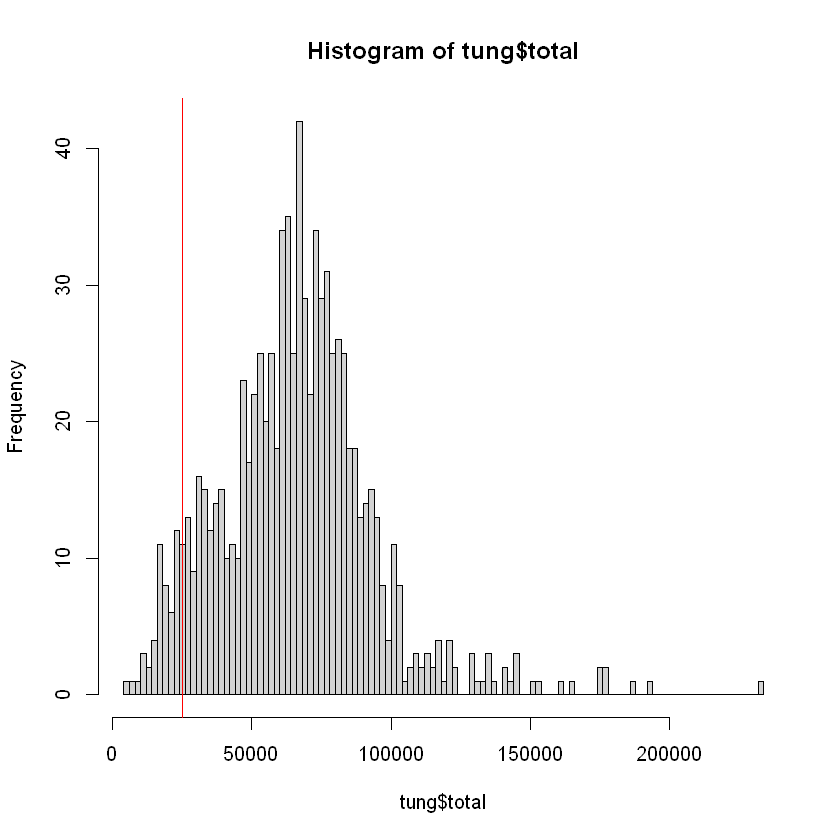

In [84]:
hist(
    tung$total,
    breaks = 100
)
abline(v = 25000, col = "red") # adds cutoff on plot

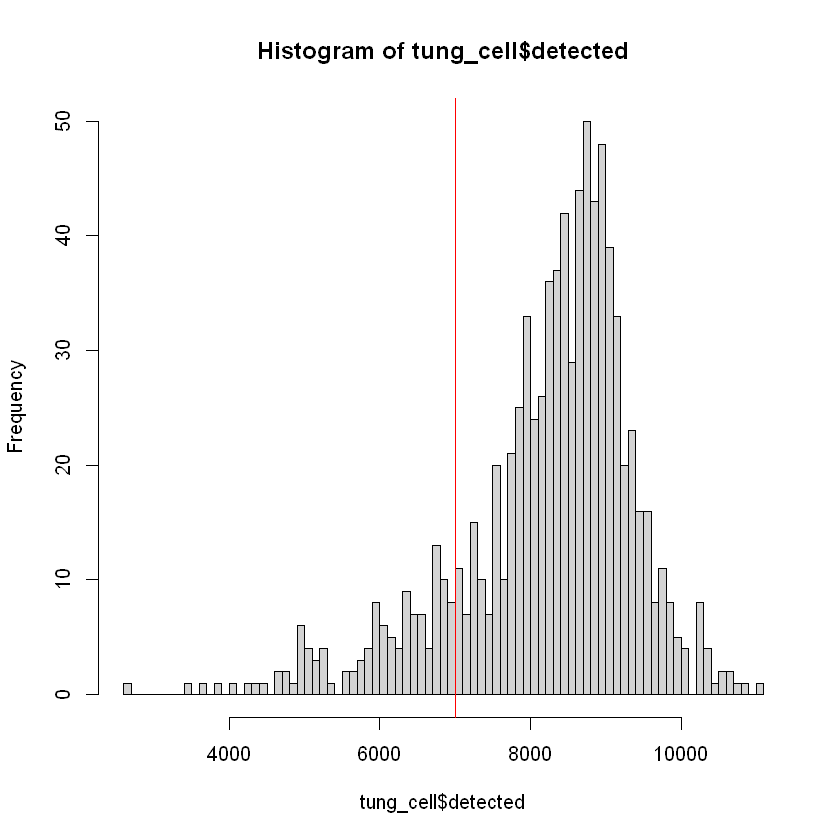

In [85]:
hist(
  tung_cell$detected,
  breaks = 100
)
abline(v = 7000, col = "red")